In [862]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# all data is from kaggle dataset

def generate_tourney_stats(team_dict, team: str, path=r'data\MNCAATourneyDetailedResults.csv') -> pd.DataFrame:
    tourney_data = pd.read_csv(path)

    wins = tourney_data[tourney_data['WTeamID'] == team_dict[team]].groupby('Season').agg(
        TourWins=('WTeamID', 'count'),
        WTourScoreMean=('WScore', 'mean'),
        ).reset_index()

    losses = tourney_data[tourney_data['LTeamID'] == team_dict[team]].groupby('Season').agg(
        TourLosses=('LTeamID', 'count'),
        LTourScore=('LScore', 'mean'),
    ).reset_index()
    
    score_data = wins.merge(losses, on='Season', how='outer')
    score_data = score_data.fillna(0)
    return score_data

def generate_reg_stats(team_dict, team: str, path=r'data\MRegularSeasonDetailedResults.csv'):
    reg_data = pd.read_csv(path)

    reg_stats = reg_data[(reg_data['WTeamID'] == team_dict[team]) | (reg_data['LTeamID'] == team_dict[team])].copy()
    reg_stats['Win'] = (reg_stats['WTeamID'] == team_dict[team]).astype(int)
    reg_stats['Score'] = np.where(reg_stats['Win'], reg_stats['WScore'], reg_stats['LScore'])
    reg_stats['OppScore'] = np.where(reg_stats['Win'], reg_stats['LScore'], reg_stats['WScore'])
    reg_stats['FG2A'] = np.where(reg_stats['Win'], reg_stats['WFGA'] - reg_stats['WFGA3'], reg_stats['LFGA'] - reg_stats['LFGA3'])
    reg_stats['FG2M'] = np.where(reg_stats['Win'], reg_stats['WFGM'] - reg_stats['WFGM3'], reg_stats['LFGM'] - reg_stats['LFGM3'])
    reg_stats['FG3A'] = np.where(reg_stats['Win'], reg_stats['WFGA3'], reg_stats['LFGA3'])
    reg_stats['FG3M'] = np.where(reg_stats['Win'], reg_stats['WFGM3'], reg_stats['LFGM3'])
    reg_stats['FTA'] = np.where(reg_stats['Win'], reg_stats['WFTA'], reg_stats['LFTA'])
    reg_stats['FTM'] = np.where(reg_stats['Win'], reg_stats['WFTM'], reg_stats['LFTM'])
    reg_stats['TO'] = np.where(reg_stats['Win'], reg_stats['WTO'], reg_stats['LTO'])
    reg_stats['Stl'] = np.where(reg_stats['Win'], reg_stats['WStl'], reg_stats['LStl'])
    reg_stats['Blk'] = np.where(reg_stats['Win'], reg_stats['WBlk'], reg_stats['LBlk'])
    reg_stats['OR'] = np.where(reg_stats['Win'], reg_stats['WOR'], reg_stats['LOR'])
    reg_stats['DR'] = np.where(reg_stats['Win'], reg_stats['WDR'], reg_stats['LDR'])

    score_data = reg_stats.groupby('Season').agg(
        Wins=('Win', 'sum'),
        ScoreMean=('Score', 'mean'),
        ScoreVar=('Score', 'var'),
        OppScoreMean=('OppScore', 'mean'),
        OppScoreVar=('OppScore', 'var'),
        FG2Att=('FG2A', 'mean'),
        FG2Made=('FG2M', 'mean'),
        FG3Att=('FG3A', 'mean'),
        FG3Made=('FG3M', 'mean'),
        FTAtt=('FTA', 'mean'),
        FTMade=('FTM', 'mean'),
        TO=('TO', 'mean'),
        Stl=('Stl', 'mean'),
        Blk=('Blk', 'mean'),
        OR=('OR', 'mean'),
        DR=('DR', 'mean'),
    ).reset_index()

    score_data.fillna(0)
    score_data['TeamID'] = team_dict[team]

    return score_data

In [727]:
men_teams = pd.read_csv('data/MTeams.csv')
# quickly take a look at how the teams are organized
team_dict = men_teams.set_index('TeamName')['TeamID'].to_dict()

In [863]:
# test
generate_reg_stats(team_dict, 'Kansas').head()

,Season,Wins,ScoreMean,ScoreVar,OppScoreMean,OppScoreVar,FG2Att,FG2Made,FG3Att,FG3Made,FTAtt,FTMade,TO,Stl,Blk,OR,DR,TeamID
0,2003,23,81.333333,148.643678,66.366667,160.998851,48.166667,25.433333,14.133333,4.800000,24.133333,16.066667,14.900000,10.133333,4.900000,14.300000,26.900000,1242
1,2004,20,74.857143,126.793651,68.178571,102.003968,40.964286,21.178571,17.178571,5.750000,21.571429,15.250000,14.428571,6.892857,4.928571,12.071429,26.500000,1242
2,2005,23,75.448276,107.970443,65.241379,68.403941,38.275862,20.137931,18.206897,6.793103,21.448276,14.793103,14.482759,6.620690,3.862069,11.793103,25.965517,1242
3,2006,24,74.354839,148.769892,61.064516,134.195699,41.548387,21.129032,16.322581,6.161290,20.451613,13.612903,15.645161,9.677419,5.774194,13.161290,26.161290,1242
4,2007,30,78.441176,131.284314,61.029412,170.332442,43.647059,23.088235,15.647059,5.970588,21.529412,14.352941,14.000000,8.911765,6.676471,13.058824,27.323529,1242


In [729]:
data_lst = []
for team in team_dict:
    data = generate_reg_stats(team_dict, team)
    data = data.query('Season != 2020 and Season != 2025') # covid and 2025 isn't over yet
    data['ID'] = team_dict[team]
    data['Name'] = team

    data_lst.append(data)

combined = pd.concat(data_lst, ignore_index=True)
combined

,Season,Wins,ScoreMean,ScoreVar,OppScoreMean,OppScoreVar,FG2Att,FG2Made,FG3Att,FG3Made,FTAtt,FTMade,TO,Stl,Blk,OR,DR,TeamID,ID,Name
0,2014,2,63.142857,201.728571,78.619048,132.647619,32.285714,13.666667,17.857143,6.666667,21.190476,15.809524,15.000000,5.761905,1.476190,8.000000,20.333333,1101,1101,Abilene Chr
1,2015,7,61.000000,260.962963,71.857143,118.126984,33.750000,14.178571,19.178571,7.250000,14.964286,10.892857,12.821429,5.928571,1.178571,8.250000,19.642857,1101,1101,Abilene Chr
2,2016,9,69.851852,139.054131,76.259259,127.045584,35.074074,16.962963,18.851852,6.851852,21.740741,15.370370,13.407407,6.740741,2.444444,8.185185,22.518519,1101,1101,Abilene Chr
3,2017,9,67.880000,132.693333,72.640000,107.906667,34.240000,17.360000,19.080000,7.080000,18.560000,11.920000,14.480000,7.000000,2.760000,7.560000,22.880000,1101,1101,Abilene Chr
4,2018,12,70.666667,88.000000,72.814815,60.618234,36.518519,19.037037,19.962963,6.481481,18.666667,13.148148,14.407407,7.148148,3.629630,9.037037,23.222222,1101,1101,Abilene Chr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,2023,13,66.133333,172.326437,70.400000,182.731034,30.800000,15.366667,21.633333,7.533333,16.866667,12.800000,12.800000,6.966667,2.833333,4.966667,22.533333,1476,1476,Stonehill
7260,2024,3,63.200000,77.131034,77.200000,198.372414,30.733333,14.733333,27.200000,8.200000,13.100000,9.133333,12.966667,6.266667,2.366667,6.866667,23.066667,1476,1476,Stonehill
7261,2023,12,70.656250,95.329637,74.218750,133.079637,30.843750,17.343750,25.843750,8.250000,16.031250,11.218750,12.437500,5.562500,2.875000,7.500000,21.093750,1477,1477,East Texas A&M
7262,2024,10,67.266667,264.409195,76.600000,106.731034,32.066667,15.266667,27.333333,8.033333,18.266667,12.633333,11.000000,7.366667,4.566667,7.500000,20.333333,1477,1477,East Texas A&M


In [730]:
# merge tournament results
tour_results = pd.read_csv(r'data\MNCAATourneyCompactResults.csv')[['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore']]
tour_results = tour_results[tour_results['Season'] >= 2003].reset_index(drop=True)
final_df = tour_results.merge(combined, left_on=['Season', 'WTeamID'], right_on=['Season', 'ID'], suffixes=('_W', '_L'))
final_df = final_df.merge(combined, left_on=['Season', 'LTeamID'], right_on=['Season', 'ID'], suffixes=('_W', '_L'))
final_df.drop(columns=['TeamID_W', 'TeamID_L', 'ID_W', 'ID_L'], inplace=True)
# merge team seeding
seed_data = pd.read_csv(r'data\MNCAATourneySeeds.csv')

final_df = final_df.merge(seed_data, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], suffixes=('_W', '_L'))
final_df.drop(columns=['TeamID'], inplace=True)
final_df = final_df.merge(seed_data, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], suffixes=('_W', '_L'))
final_df.drop(columns=['TeamID'], inplace=True)

final_df['Seed_W'] = final_df['Seed_W'].str[1:3].astype(int)
final_df['Seed_L'] = final_df['Seed_L'].str[1:3].astype(int)
final_df['ScoreDiff'] = final_df['WScore'] - final_df['LScore']
final_df['SeedDiff'] = final_df['Seed_W'] - final_df['Seed_L']
final_df.drop(columns=['Seed_L', 'Seed_W'], inplace=True)

# get data to csv file called final.csv, unless you want to add new data can start below here for analysis
final_df.to_csv('final.csv', index=False)

print(final_df.columns)
final_df.head()

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'Wins_W',
       'ScoreMean_W', 'ScoreVar_W', 'OppScoreMean_W', 'OppScoreVar_W',
       'FG2Att_W', 'FG2Made_W', 'FG3Att_W', 'FG3Made_W', 'FTAtt_W', 'FTMade_W',
       'TO_W', 'Stl_W', 'Blk_W', 'OR_W', 'DR_W', 'Name_W', 'Wins_L',
       'ScoreMean_L', 'ScoreVar_L', 'OppScoreMean_L', 'OppScoreVar_L',
       'FG2Att_L', 'FG2Made_L', 'FG3Att_L', 'FG3Made_L', 'FTAtt_L', 'FTMade_L',
       'TO_L', 'Stl_L', 'Blk_L', 'OR_L', 'DR_L', 'Name_L', 'ScoreDiff',
       'SeedDiff'],
      dtype='object')


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Wins_W,ScoreMean_W,ScoreVar_W,OppScoreMean_W,...,FTAtt_L,FTMade_L,TO_L,Stl_L,Blk_L,OR_L,DR_L,Name_L,ScoreDiff,SeedDiff
0,2003,134,1421,92,1411,84,13,71.206897,135.455665,78.448276,...,28.066667,17.400000,15.233333,6.433333,2.233333,13.166667,24.800000,TX Southern,8,0
1,2003,136,1112,80,1436,51,25,85.214286,107.730159,70.250000,...,19.551724,12.862069,14.068966,6.862069,2.965517,12.965517,25.724138,Vermont,29,-15
2,2003,136,1113,84,1272,71,18,75.965517,143.248768,69.172414,...,22.896552,14.965517,13.793103,7.379310,5.068966,14.068966,25.965517,Memphis,13,3
3,2003,136,1141,79,1166,73,23,79.344828,171.662562,73.241379,...,20.030303,13.878788,13.363636,8.393939,4.454545,10.878788,23.181818,Creighton,6,5
4,2003,136,1143,76,1301,74,21,74.482759,60.187192,69.758621,...,20.466667,15.766667,14.200000,7.766667,3.066667,9.733333,22.033333,NC State,2,-1


In [731]:
final_df.corr(numeric_only=True)[['ScoreDiff']]

,ScoreDiff
Season,0.048794
DayNum,-0.106519
WTeamID,-0.025176
WScore,0.447645
LTeamID,-0.050507
LScore,-0.371710
Wins_W,0.200849
ScoreMean_W,0.158806
ScoreVar_W,-0.002584
OppScoreMean_W,-0.024121


In [734]:
final_df = pd.read_csv('final.csv')
X_data = final_df.copy()

y_data = np.ones(len(X_data))

# flipping around half of rows to model wins and losses
flip_mask = np.random.rand(len(X_data)) < 0.5
X_data.columns = X_data.columns.str.replace('_W', '_A').str.replace('_L', '_B') 

a_cols = [col for col in X_data.columns if col.endswith('_A')]
b_cols = [col.replace('_A', '_B') for col in a_cols]

X_data.loc[flip_mask, a_cols], X_data.loc[flip_mask, b_cols] = (
    X_data.loc[flip_mask, b_cols].to_numpy(),
    X_data.loc[flip_mask, a_cols].to_numpy()
)

y_data[flip_mask] = 0
X_data.loc[flip_mask, 'ScoreDiff'] *= -1
X_data.loc[flip_mask, 'SeedDiff'] *= -1

X_data['RegMeanScoreDiff'] = X_data['ScoreMean_A'] - X_data['ScoreMean_B']
X_data['RegMeanOppScoreDiff'] = X_data['OppScoreMean_A'] - X_data['OppScoreMean_B']

X_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Wins_A,ScoreMean_A,ScoreVar_A,OppScoreMean_A,...,TO_B,Stl_B,Blk_B,OR_B,DR_B,Name_B,ScoreDiff,SeedDiff,RegMeanScoreDiff,RegMeanOppScoreDiff
0,2003,134,1421,92,1411,84,18,72.800000,146.510345,70.833333,...,16.206897,7.068966,3.000000,12.275862,23.172414,UNC Asheville,-8,0,1.593103,-7.614943
1,2003,136,1112,80,1436,51,19,67.793103,143.884236,63.137931,...,14.785714,8.464286,4.214286,15.178571,27.642857,Arizona,-29,15,-17.421182,-7.112069
2,2003,136,1113,84,1272,71,18,75.965517,143.248768,69.172414,...,13.793103,7.379310,5.068966,14.068966,25.965517,Memphis,13,3,1.448276,3.344828
3,2003,136,1141,79,1166,73,23,79.344828,171.662562,73.241379,...,13.363636,8.393939,4.454545,10.878788,23.181818,Creighton,6,5,0.102403,8.908046
4,2003,136,1143,76,1301,74,18,72.400000,161.213793,68.000000,...,14.172414,6.551724,2.793103,11.241379,24.379310,California,-2,1,-2.082759,-1.758621


In [808]:
X_features = X_data.copy()

# incorporate some feature interactions here
X_features['WinRatio'] = X_features['Wins_A'] / X_features['Wins_B']

X_features['FG2Att_Ratio'] = X_features['FG2Att_A'] / X_features['FG2Att_B']
X_features['FG2%_Ratio'] = (X_features['FG2Made_A'] / X_features['FG2Att_A']) / (X_features['FG2Made_B'] / X_features['FG2Att_B'])
X_features['FG3Att_Ratio'] = X_features['FG3Att_A'] / X_features['FG3Att_B']
X_features['FG3%_Ratio'] = (X_features['FG3Made_A'] / X_features['FG3Att_A']) / (X_features['FG3Made_B'] / X_features['FG3Att_B'])

X_features['Rebounds_A'] = X_features['OR_A'] * X_features['DR_A']
X_features['Rebounds_B'] = X_features['OR_B'] * X_features['DR_B']
X_features['Rebounds_Ratio'] = X_features['Rebounds_A'] / X_features['Rebounds_B']

X_features['Blk_Ratio'] = X_features['Blk_A'] / X_features['Blk_B']
X_features['Stl_Ratio'] = X_features['Stl_A'] / X_features['Stl_B']
X_features['TO_Ratio'] = X_features['TO_A'] / X_features['TO_B']

X_features['Rebounds&Score_Ratio'] = (X_features['Rebounds_A'] * X_features['ScoreMean_A']) / (X_features['Rebounds_B'] * X_features['ScoreMean_B'])
X_features['TO_to_FGAtt_Ratio'] = (X_features['TO_A'] / (X_features['FG2Att_A'] + X_features['FG3Att_A'])) / (X_features['TO_B'] / (X_features['FG2Att_B'] + X_features['FG3Att_B']))

X = X_features[['SeedDiff', 'TO_to_FGAtt_Ratio', 'FG2%_Ratio', 'FG3%_Ratio', 'Rebounds&Score_Ratio']].copy()

accuracies = []
for _ in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=random.randint(1, 5000))
    lr = LogisticRegression(penalty='l2', max_iter=300)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

print('Average Accuracy:', np.mean(accuracies))

coefficients = lr.coef_[0]
col_names = X.columns
coef_df = pd.DataFrame({'Measure':col_names, 'Coef':coefficients})
coef_df

Average Accuracy: 0.6965884476534295


,Measure,Coef
0,SeedDiff,-0.145991
1,TO_to_FGAtt_Ratio,-1.030090
2,FG2%_Ratio,1.144141
3,FG3%_Ratio,0.080307
4,Rebounds&Score_Ratio,0.163267


After experimenting with various feature combinations, around 70% is the maximum accuracy with linear logistic regression

In [861]:
# try gradient boosting

import xgboost as xgb


X = X_features[['SeedDiff', 'TO_to_FGAtt_Ratio', 'FG2%_Ratio', 'FG3%_Ratio', 'Rebounds&Score_Ratio']]
accuracies = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=random.randint(1, 5000))
    xgb_model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=.01,
        max_depth=4,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=random.randint(1, 5000),
        gamma=0.4,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
print('Average Accuracy:', np.mean(accuracies))

Average Accuracy: 0.6848014440433211


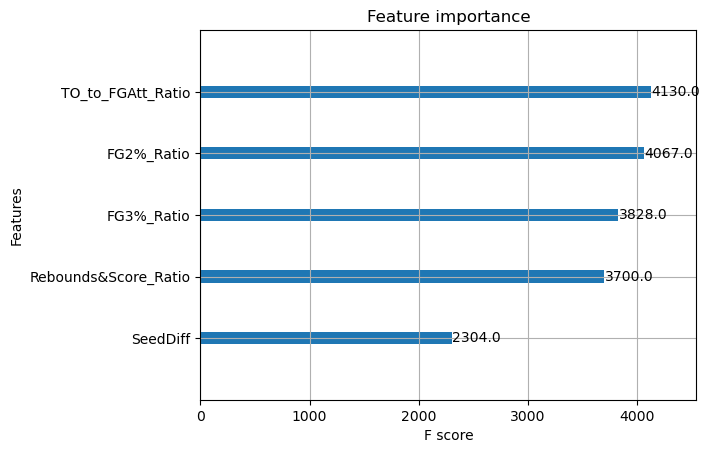

In [ ]:
# take a look at most important features

from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model, max_num_features=10)
plt.show()